In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

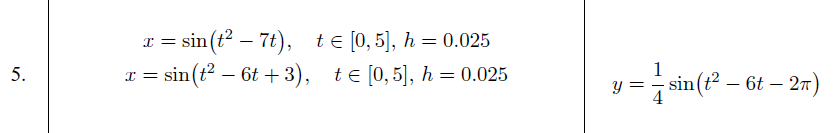

In [2]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def sko(y_true, y_pred):
    rmse = r2_score(y_true, y_pred)
    return (rmse / (y_true.max() - y_true.min())) * 100


def min_max_error(y_true, y_pred):
    diff = abs(y_true - y_pred)
    return diff.min(), diff.max()


def fraction_error(y_true, y_pred):
    return (abs(y_true - y_pred)) / y_true * 100

# Реализация сети 

In [3]:
class Adaline(nn.Module):

    def __init__(self, delays):
        super().__init__()
        self.delays = delays
        self.fc = nn.Linear(delays, 1)

    def forward(self, x):
        x = self.fc(x)
        return x
    
    def fit(self, X, y, num_epochs, lr, early_stopping = 1e-6):
        out = torch.zeros(X.shape[0])
        err = []
        for i in range(num_epochs):
            squared_error = 0
            for i in range(X.shape[0] - self.delays):
                x = torch.tensor([X[i + lag] for lag in range(self.delays)], dtype = torch.float32)
                out[i + self.delays] = self.forward(x)
                error = out[i + self.delays] - y[i + self.delays]  
                with torch.no_grad():
                    self.fc.weight -= lr * error * x
                    self.fc.bias -= lr * error
                    squared_error += ((out[i + self.delays].item() - y[i + self.delays].item()) ** 2)
            err.append(squared_error) 
            if np.sqrt(squared_error / (X.shape[0] - self.delays)) < early_stopping:
                break   
        return out, err
    
    def fit_predict(self, X, y, step, num_epochs, lr):
        if self.delays < step:
            self.pred_range = step
        else:
            self.pred_range = self.delays
        out = torch.zeros(X.shape[0] - self.pred_range)
        err = []
        for i in range(num_epochs):
            squared_error = 0
            for i in range(X.shape[0] - self.pred_range):
                x = torch.tensor([X[i + lag] for lag in range(self.delays)], dtype = torch.float32)
                out[i] = self.forward(x)
                error = out[i] - y[i + step]  
                with torch.no_grad():
                    self.fc.weight -= lr * error * x
                    self.fc.bias -= lr * error
                    squared_error += ((out[i].item() - y[i + step].item()) ** 2)
            err.append(squared_error)   
        return out, err
    

# Задание 1. Аппроксимация

## Инициализация последовательности

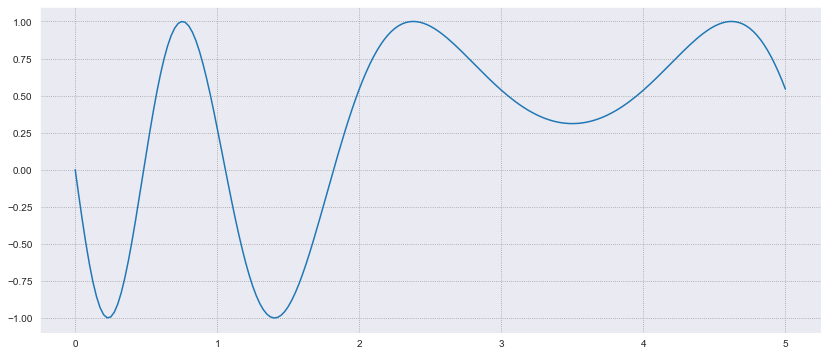

In [12]:
def f1(t):
    return torch.sin(t ** 2 - 7 * t)

start = 0
end = 5
h = 0.025

time = torch.arange(start, end + h, h)

X = torch.tensor([f1(t) for t in time])

plt.figure(figsize=(14,6))
sns.lineplot(x = time, y = X)
plt.show()

## Прогноз

In [13]:
model = Adaline(delays = 5)
print(model)

Adaline(
  (fc): Linear(in_features=5, out_features=1, bias=True)
)


In [14]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Initial weights: {w}')
print(f'Initial bias: {b}')

Initial weights: tensor([-0.4218,  0.4460,  0.4391,  0.4289, -0.4027])
Initial bias: tensor([0.0874])


In [15]:
res, err = model.fit(X=X, y=X, num_epochs=50, lr=0.01)

In [16]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Final weights: {w}')
print(f'Final bias: {b}')

Final weights: tensor([-0.8698,  0.2644,  0.5309,  0.7968,  0.2392])
Final bias: tensor([0.0167])


In [17]:
loss = np.sqrt(err[-1] / max(1, time.shape[0] - model.delays))
print("RMSE = ", loss)

RMSE =  0.0231467097605055


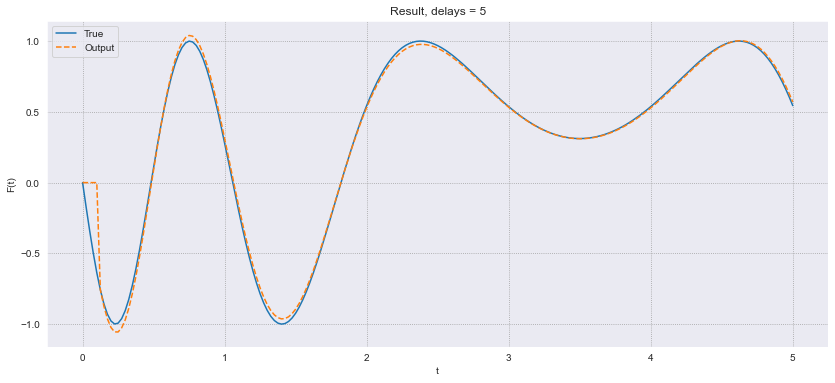

In [18]:
plt.figure(figsize=(14,6))
sns.lineplot(x = time, y = X)
sns.lineplot(x = time, y = res.detach().numpy(), linestyle='--')
plt.title(f'Result, delays = {model.delays}')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend(['True', 'Output'])
plt.show()

In [19]:
y_true = X.detach().numpy().reshape(-1)
y_pred = res.detach().numpy().reshape(-1)

print(f'R2_score = {r2_score(y_true, y_pred)}')

print(f'MSE = {mean_squared_error(y_true, y_pred)}')

print(f'RMSE = {np.sqrt(mean_squared_error(y_true, y_pred))}')

print(f'Относительная СКО = {sko(y_true, y_pred)} %')

print(f'MAE = {mean_absolute_error(y_true, y_pred)}')

min_err, max_err = min_max_error(y_true, y_pred)
print(f'Min absolute error = {min_err}')
print(f'Max absolute error = {max_err}')

print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')

frac = fraction_error(y_true, y_pred)
print(f'Доля с ошибкой менее 5% = {len(frac[frac <= 5]) / len(frac) * 100} %')
print(f'Доля с ошибкой 5 - 10 % = {len(frac[(frac > 5) & (frac <= 10)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 10 - 20 % = {len(frac[(frac > 10) & (frac <= 20)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 20 - 30 % = {len(frac[(frac > 20) & (frac <= 30)]) / len(frac) * 100} %')
print(f'Доля с ошибкой более 30 % = {len(frac[frac > 30]) / len(frac) * 100} %')

R2_score = 0.9882964110893904
MSE = 0.00449061905965209
RMSE = 0.06701207906007767
Относительная СКО = 49.41878531745745 %
MAE = 0.025220533832907677
Min absolute error = 0.0
Max absolute error = 0.6365371942520142
MAPE = 0.056411582976579666
Доля с ошибкой менее 5% = 95.02487562189054 %
Доля с ошибкой 5 - 10 % = 2.4875621890547266 %
Доля с ошибкой 10 - 20 % = 0.9950248756218906 %
Доля с ошибкой 20 - 30 % = 0.4975124378109453 %
Доля с ошибкой более 30 % = 0.4975124378109453 %


C:\Users\stasa\AppData\Local\Temp/ipykernel_10056/4123647893.py:14: RuntimeWarning: invalid value encountered in true_divide
  return (abs(y_true - y_pred)) / y_true * 100


# Задание 2. Прогноз

## Прогноз на один шаг

In [20]:
model = Adaline(delays = 3)
print(model)

Adaline(
  (fc): Linear(in_features=3, out_features=1, bias=True)
)


In [21]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Initial weights: {w}')
print(f'Initial bias: {b}')

Initial weights: tensor([-0.0189,  0.2766, -0.5699])
Initial bias: tensor([0.3326])


In [22]:
res, err = model.fit_predict(X=X, y=X, step = 1,  num_epochs=600, lr=0.01)

In [23]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Final weights: {w}')
print(f'Final bias: {b}')

Final weights: tensor([0.1393, 0.7198, 0.1421])
Final bias: tensor([-0.0005])


In [24]:
loss = np.sqrt(err[-1] / max(1, time.shape[0] - model.delays))
print("RMSE = ", loss)

RMSE =  0.0006477826003947945


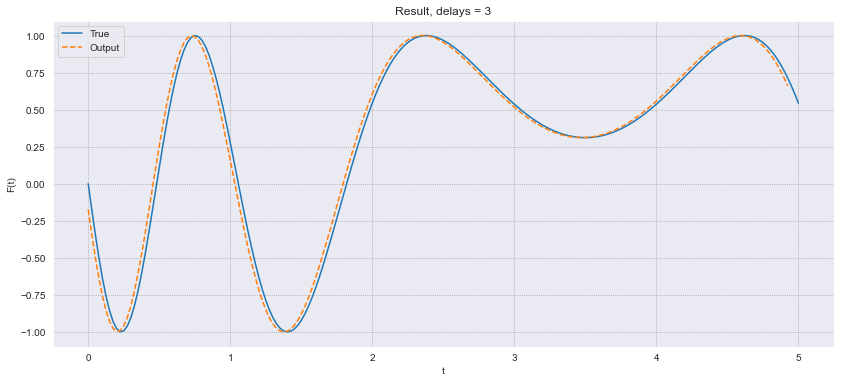

In [25]:
plt.figure(figsize=(14,6))
sns.lineplot(x = time, y = X)
sns.lineplot(x = time[:-model.pred_range], y= res.detach().numpy(), linestyle='--')
plt.title(f'Result, delays = {model.delays}')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend(['True', 'Output'])
plt.show()

In [37]:
X[2], res[1]

(tensor(-0.3405), tensor(-0.3403, grad_fn=<SelectBackward>))

In [39]:
y_true = X[1:-2].detach().numpy().reshape(-1)
y_pred = res.detach().numpy().reshape(-1)

print(f'R2_score = {r2_score(y_true, y_pred)}')

print(f'MSE = {mean_squared_error(y_true, y_pred)}')

print(f'RMSE = {np.sqrt(mean_squared_error(y_true, y_pred))}')

print(f'Относительная СКО = {sko(y_true, y_pred)} %')

print(f'MAE = {mean_absolute_error(y_true, y_pred)}')

min_err, max_err = min_max_error(y_true, y_pred)
print(f'Min absolute error = {min_err}')
print(f'Max absolute error = {max_err}')

print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')

frac = fraction_error(y_true, y_pred)
print(f'Доля с ошибкой менее 5% = {len(frac[frac <= 5]) / len(frac) * 100} %')
print(f'Доля с ошибкой 5 - 10 % = {len(frac[(frac > 5) & (frac <= 10)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 10 - 20 % = {len(frac[(frac > 10) & (frac <= 20)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 20 - 30 % = {len(frac[(frac > 20) & (frac <= 30)]) / len(frac) * 100} %')
print(f'Доля с ошибкой более 30 % = {len(frac[frac > 30]) / len(frac) * 100} %')

R2_score = 0.9999989194770469
MSE = 4.196222676000616e-07
RMSE = 0.0006477825809270144
Относительная СКО = 50.003957683962206 %
MAE = 0.0004942169180139899
Min absolute error = 1.1563301086425781e-05
Max absolute error = 0.0018482804298400879
MAPE = 0.0010080483043566346
Доля с ошибкой менее 5% = 100.0 %
Доля с ошибкой 5 - 10 % = 0.0 %
Доля с ошибкой 10 - 20 % = 0.0 %
Доля с ошибкой 20 - 30 % = 0.0 %
Доля с ошибкой более 30 % = 0.0 %


## Прогноз на 10 шагов

In [40]:
model = Adaline(delays = 3)
print(model)

Adaline(
  (fc): Linear(in_features=3, out_features=1, bias=True)
)


In [41]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Initial weights: {w}')
print(f'Initial bias: {b}')

Initial weights: tensor([-0.3646, -0.1897, -0.4740])
Initial bias: tensor([0.0523])


In [42]:
res, err = model.fit_predict(X=X, y=X, step = 10,  num_epochs=600, lr=0.01)

In [43]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Final weights: {w}')
print(f'Final bias: {b}')

Final weights: tensor([-2.9297,  0.1622,  3.4975])
Final bias: tensor([0.1435])


In [44]:
loss = np.sqrt(err[-1] / max(1, time.shape[0] - model.delays))
print("RMSE = ", loss)

RMSE =  0.15408235872728038


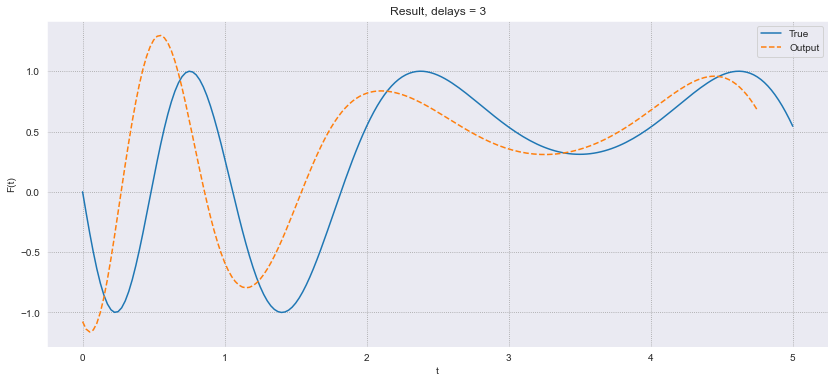

In [45]:
plt.figure(figsize=(14,6))
sns.lineplot(x = time, y = X)
sns.lineplot(x = time[:-model.pred_range], y= res.detach().numpy(), linestyle='--')
plt.title(f'Result, delays = {model.delays}')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend(['True', 'Output'])
plt.show()

In [46]:
y_true = X[10:].detach().numpy().reshape(-1)
y_pred = res.detach().numpy().reshape(-1)

print(f'R2_score = {r2_score(y_true, y_pred)}')

print(f'MSE = {mean_squared_error(y_true, y_pred)}')

print(f'RMSE = {np.sqrt(mean_squared_error(y_true, y_pred))}')

print(f'Относительная СКО = {sko(y_true, y_pred)} %')

print(f'MAE = {mean_absolute_error(y_true, y_pred)}')

min_err, max_err = min_max_error(y_true, y_pred)
print(f'Min absolute error = {min_err}')
print(f'Max absolute error = {max_err}')

print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')

frac = fraction_error(y_true, y_pred)
print(f'Доля с ошибкой менее 5% = {len(frac[frac <= 5]) / len(frac) * 100} %')
print(f'Доля с ошибкой 5 - 10 % = {len(frac[(frac > 5) & (frac <= 10)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 10 - 20 % = {len(frac[(frac > 10) & (frac <= 20)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 20 - 30 % = {len(frac[(frac > 20) & (frac <= 30)]) / len(frac) * 100} %')
print(f'Доля с ошибкой более 30 % = {len(frac[frac > 30]) / len(frac) * 100} %')

R2_score = 0.9293175654793888
MSE = 0.02461147867143154
RMSE = 0.1568804532289505
Относительная СКО = 46.46960643067051 %
MAE = 0.12005840986967087
Min absolute error = 0.001107335090637207
Max absolute error = 0.39486271142959595
MAPE = 0.3374839127063751
Доля с ошибкой менее 5% = 39.26701570680628 %
Доля с ошибкой 5 - 10 % = 17.801047120418847 %
Доля с ошибкой 10 - 20 % = 31.413612565445025 %
Доля с ошибкой 20 - 30 % = 2.6178010471204187 %
Доля с ошибкой более 30 % = 8.900523560209423 %


# Задание 3. Адаптивный линейный фильтр

## Инициализация последовательности

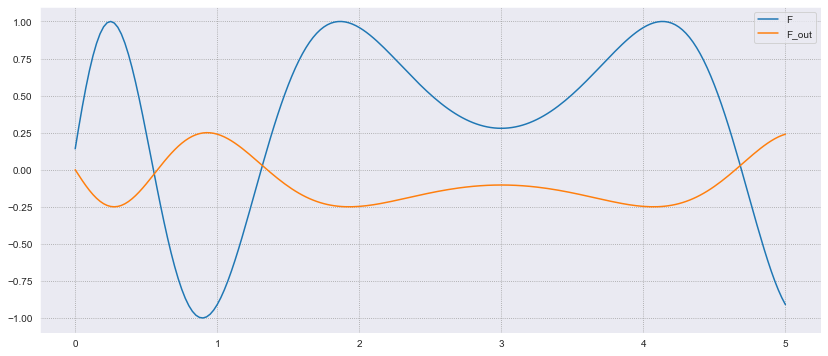

In [4]:
def f2(t):
    return torch.sin(t ** 2 - 6 * t + 3)

def f_out(t):
    return 0.25 * torch.sin(t ** 2 - 6 * t - 2 * np.pi)

start = 0
end = 5
h = 0.025

time = torch.arange(start, end + h, h)

X = torch.tensor([f2(t) for t in time])

y = torch.tensor([f_out(t) for t in time])

plt.figure(figsize=(14,6))
sns.lineplot(x = time, y = X)
sns.lineplot(x = time, y = y)
plt.legend(['F', 'F_out'])
plt.show()

## Прогноз

In [5]:
model = Adaline(delays = 4)
print(model)

Adaline(
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


In [6]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Initial weights: {w}')
print(f'Initial bias: {b}')

Initial weights: tensor([-0.0348,  0.2922, -0.4039,  0.1679])
Initial bias: tensor([0.4856])


In [7]:
res, err = model.fit(X=X, y=y, num_epochs=500, lr=0.01)

In [8]:
w = model.fc.weight.data[0]
b = model.fc.bias.data
print(f'Final weights: {w}')
print(f'Final bias: {b}')

Final weights: tensor([ 0.0103,  0.2749, -0.5018, -0.0303])
Final bias: tensor([0.0078])


In [9]:
loss = np.sqrt(err[-1] / max(1, time.shape[0] - model.delays))
print("RMSE = ", loss)

RMSE =  0.02223446133574581


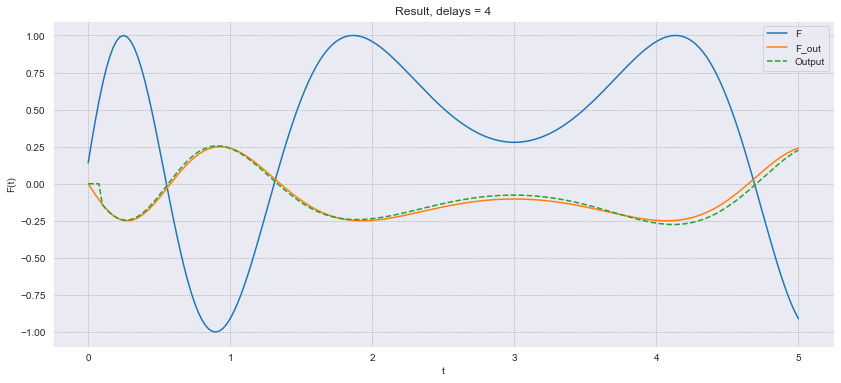

In [10]:
plt.figure(figsize=(14,6))
sns.lineplot(x = time, y = X)
sns.lineplot(x = time, y = y)
sns.lineplot(x = time, y = res.detach().numpy(), linestyle='--')
plt.title(f'Result, delays = {model.delays}')
plt.xlabel('t')
plt.ylabel('F(t)')
plt.legend(['F','F_out', 'Output'])
plt.show()

In [11]:
y_true = y.detach().numpy().reshape(-1)
y_pred = res.detach().numpy().reshape(-1)

print(f'R2_score = {r2_score(y_true, y_pred)}')

print(f'MSE = {mean_squared_error(y_true, y_pred)}')

print(f'RMSE = {np.sqrt(mean_squared_error(y_true, y_pred))}')

print(f'Относительная СКО = {sko(y_true, y_pred)} %')

print(f'MAE = {mean_absolute_error(y_true, y_pred)}')

min_err, max_err = min_max_error(y_true, y_pred)
print(f'Min absolute error = {min_err}')
print(f'Max absolute error = {max_err}')

print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')

frac = fraction_error(y_true, y_pred)
print(f'Доля с ошибкой менее 5% = {len(frac[frac <= 5]) / len(frac) * 100} %')
print(f'Доля с ошибкой 5 - 10 % = {len(frac[(frac > 5) & (frac <= 10)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 10 - 20 % = {len(frac[(frac > 10) & (frac <= 20)]) / len(frac) * 100} %')
print(f'Доля с ошибкой 20 - 30 % = {len(frac[(frac > 20) & (frac <= 30)]) / len(frac) * 100} %')
print(f'Доля с ошибкой более 30 % = {len(frac[frac > 30]) / len(frac) * 100} %')

R2_score = 0.9741972949968776
MSE = 0.0005756033351644874
RMSE = 0.02399173565208912
Относительная СКО = 194.85588164164474 %
MAE = 0.01956496573984623
Min absolute error = 4.371138828673793e-08
Max absolute error = 0.1074734628200531
MAPE = 0.4283416271209717
Доля с ошибкой менее 5% = 82.58706467661692 %
Доля с ошибкой 5 - 10 % = 4.477611940298507 %
Доля с ошибкой 10 - 20 % = 4.975124378109453 %
Доля с ошибкой 20 - 30 % = 1.9900497512437811 %
Доля с ошибкой более 30 % = 5.970149253731343 %
